***This notebook is built off of Germano's existing LSCP notebook:

***Objective:  Attempt to solve the Location Coverage Backup Problem as a script and access PuLP manually (outside of PySAL spopt ecosystem)

***Steps:
1)  Solve for LSCP

2)  Retrieve the minimum number of facilities required from LSCP result

3)  Assign this result to variable p and use for defining LpConstraint

In [1]:
from spopt.locate.coverage import LSCP, LSCPB
from spopt.locate.util import simulated_geo_points

import numpy
import geopandas
import pulp
import spaghetti
from shapely.geometry import Point
import matplotlib.pyplot as plt

In [2]:
CLIENT_COUNT = 5 # quantity demand points
FACILITY_COUNT = 3 # quantity supply points

MAX_COVERAGE = 8 # maximum service radius in meters

# Random seeds for reproducibility
CLIENT_SEED = 5
FACILITY_SEED = 6

solver = pulp.PULP_CBC_CMD(msg=False, warmStart=True)

In [3]:
lattice = spaghetti.regular_lattice((0, 0, 10, 10), 9, exterior=True)
ntw = spaghetti.Network(in_data=lattice)

In [4]:
street = spaghetti.element_as_gdf(ntw, arcs=True)

street_buffered = geopandas.GeoDataFrame(
    geopandas.GeoSeries(street["geometry"].buffer(0.2).unary_union),
    crs=street.crs,
    columns=["geometry"],
)

<AxesSubplot:>

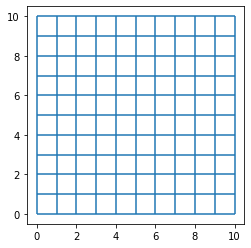

In [5]:
street.plot()

In [6]:
client_points = simulated_geo_points(street_buffered, needed=CLIENT_COUNT, seed=CLIENT_SEED)
facility_points = simulated_geo_points(
    street_buffered, needed=FACILITY_COUNT, seed=FACILITY_SEED
)

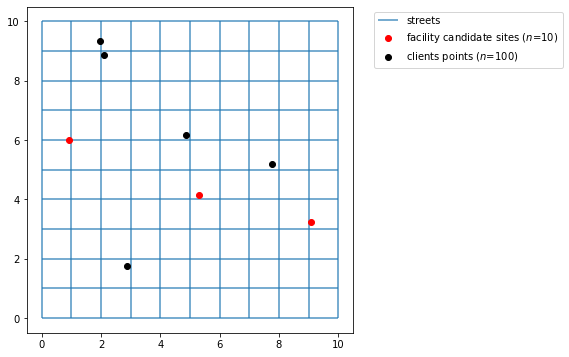

In [7]:
fig, ax = plt.subplots(figsize=(6, 6))
street.plot(ax=ax, alpha=0.8, zorder=1, label='streets')
facility_points.plot(ax=ax, color='red', zorder=2, label='facility candidate sites ($n$=10)')
client_points.plot(ax=ax, color='black', label='clients points ($n$=100)')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

In [8]:
ntw.snapobservations(client_points, "clients", attribute=True)
clients_snapped = spaghetti.element_as_gdf(
    ntw, pp_name="clients", snapped=True
)

ntw.snapobservations(facility_points, "facilities", attribute=True)
facilities_snapped = spaghetti.element_as_gdf(
    ntw, pp_name="facilities", snapped=True
)

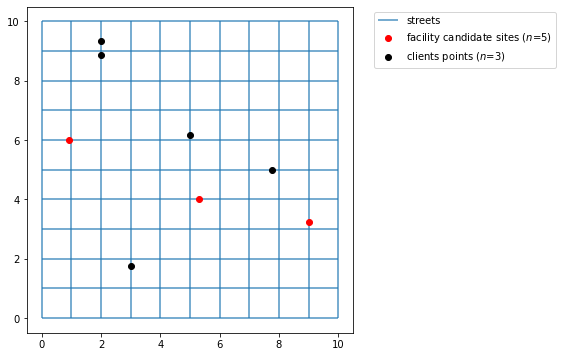

In [9]:
fig, ax = plt.subplots(figsize=(6, 6))
street.plot(ax=ax, alpha=0.8, zorder=1, label='streets')
facilities_snapped.plot(ax=ax, color='red', zorder=2, label='facility candidate sites ($n$=5)')
clients_snapped.plot(ax=ax, color='black', label='clients points ($n$=3)')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

In [10]:
cost_matrix = ntw.allneighbordistances(
    sourcepattern=ntw.pointpatterns["clients"],
    destpattern=ntw.pointpatterns["facilities"],
)

In [11]:
cost_matrix

array([[12.60302601,  3.93598651,  8.16571655],
       [13.10096347,  4.43392397,  8.66365401],
       [ 6.9095462 ,  4.2425067 ,  2.47223674],
       [ 2.98196832,  7.84581224,  3.45534114],
       [ 7.5002892 ,  6.32806975,  4.55779979]])

In [12]:
# create an array, mark values with a 1 if <= 8
# all other values marked w/ zero (no coverage)
aij = numpy.zeros(cost_matrix.shape)
aij[cost_matrix <= MAX_COVERAGE] = 1
#! aij is the coverage matrix
aij

array([[0., 1., 0.],
       [0., 1., 0.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]])

All code before this is really just setup... Now with the information we have how can we use the PuLP solver to solve for maximizing backup coverage.

First: Solve for LSCP <br>
Second: Use p (min # of facilities required) as the minimum required facilites in the LpProblem constraint.

In [13]:
lscp_from_cost_matrix = LSCP.from_cost_matrix(cost_matrix, MAX_COVERAGE)
print(lscp_from_cost_matrix.problem)
lscp_from_cost_matrix.solve(solver)

LSCP:
MINIMIZE
1*x_0_ + 1*x_1_ + 1*x_2_ + 0
SUBJECT TO
_C1: x_1_ >= 1

_C2: x_1_ >= 1

_C3: x_0_ + x_1_ + x_2_ >= 1

_C4: x_0_ + x_1_ + x_2_ >= 1

_C5: x_0_ + x_1_ + x_2_ >= 1

VARIABLES
0 <= x_0_ <= 1 Integer
0 <= x_1_ <= 1 Integer
0 <= x_2_ <= 1 Integer



In [14]:
#LSCP object attributes and methods
dir(lscp_from_cost_matrix)

#LP Problem facility variables
lscp_from_cost_matrix.fac_vars

[x_0_, x_1_, x_2_]

In [15]:
#get the minimum number of facilities needed from result
p = lscp_from_cost_matrix.problem.objective.value()
print(p)

1.0


In [16]:
if lscp_from_cost_matrix.problem.status == -1:
    print("LSCP problem is infeasible, cannot solve for backup coverage!")

In [17]:
#create a LSCPB object // solves lscp in the process
lscpb_from_cost_matrix = LSCPB.from_cost_matrix(cost_matrix, MAX_COVERAGE, solver)

lscpb_from_cost_matrix.problem

#! Subject to: isn't quite right, need to subtract coverage from left side of equation
#! one way to acheive this would be to add another @static method to the FacilityModelBuilder class in base.py
#! we currently have add_set_covering_constraint but I don't think it's sufficient 
#! for LSCP-B and from a breif glance it doesn't look like it would be very clean to try
#! and retrofit for the new model. 
#! adding a add_backup_covering_constraint method would be quite useful

#!need to double check and see if my variables are correct.....


LSCP Objective Value:  1.0
Facility Variables:  [x_0_, x_1_, x_2_]
Client Variables:  [u_0_, u_1_, u_2_, u_3_, u_4_]
# of fac_vars:  3


AttributeError: before setting constraints must set facility variable

In [ ]:
# create a LP problem with the method LpProblem in PuLP
#del(prob)
prob = pulp.LpProblem("LSCP-B", pulp.LpMaximize)

In [ ]:
#how many clients
range_client = range(cost_matrix.shape[0])

#how many facilities
range_facility = range(cost_matrix.shape[1]) 

In [ ]:
# create variables for the facilities, demand nodes, and coverage
fac_vars = [
    pulp.LpVariable(
        "facility_{}".format(i), lowBound=0, upBound=1, cat=pulp.LpInteger
    )
    for i in range_facility
]
print(fac_vars)

# coverage variable - this variable should be 1 anytime a demand node is covered > 1x
# i feel like this varibale should be created differently so that it is either assigned 0,1
# based on the coverage status of a demand node
cov_var = [
    pulp.LpVariable(
        "coverage_{}".format(i), lowBound=0, upBound=1, cat=pulp.LpInteger
    )
    for i in range_client
]
    
print(cov_var)

In [ ]:
#minimum reqired coverage
coverage_min = 2

# this is still quite useful - it describes the relationship between facilities & demand nodes
'''for i in range_client:
    prob += (
        # I should understand the below line better // maybe have them reiterate for me?
        #!lpSum( [ int( aij[i][j] ) * fac_vars[j]  for j in range_facility ] ) >= 1 + cov_var[i]
        lpSum( [ int( aij[i][j] ) * fac_vars[j]  for j in range_facility ] ) >= 1 + cov_var[i]
    )'''

for i in range_client:
    if sum(aij[i]) >= coverage_min: # demand unit has meets coverage requirement
        prob += (
            pulp.lpSum( [ int( aij[i][j] ) * fac_vars[j]  for j in range_facility ] ) >= 1 + 1*cov_var[i]
        )
    else: #demand unit does not meet coverage requirement
        prob += (
            pulp.lpSum( [ int( aij[i][j] ) * fac_vars[j]  for j in range_facility ] ) >= 1 + 0*cov_var[i]
        )

prob += pulp.lpSum(1*i for i in cov_var), "objective function"

#constraints:
#  - the number of facilities chosen should be <= p
#  - all facilities should be either 0 or 1
#  - Ui should be <= 1 

# rhs – numerical value of constraint target, which should be == p from LSCP result
prob += pulp.LpConstraint(sum(fac_vars), sense=pulp.LpConstraintEQ, rhs=p, name='Facility Constraint')

print(prob)

In [ ]:
#solve the problem
print(type(prob))
prob.solve()
'''print('Coverage Values')   
for i in cov_var:
    print(i,i.varValue)'''

print('\n'+'Total Clients Covered >= 2 Times:', pulp.value(prob.objective))

print('\n'+ 'Chosen Facility Values')
for i in fac_vars:
    if i.varValue == 1:
        print(i,i.varValue)

In [ ]:
prob.status